# To demonstrate concepts of **bias** vs **variance**

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from copy import deepcopy
from tqdm import tqdm

np.set_printoptions(precision=3, suppress=True)


# Definitions


In [2]:
def load_dataset(define_datasets_globally=False):
    if define_datasets_globally:
        global raw_dataset
        global dataset
    column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                    'Acceleration', 'Model Year', 'Origin']
    raw_dataset = pd.read_csv("./auto-mpg.data", names=column_names,
                              na_values='?', comment='\t',
                              sep=' ', skipinitialspace=True)
    dataset = raw_dataset.copy()
    # Turn last 0/1/2 categorical column in 3 binary columns:
    dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
    dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='', dtype='int')
    # Split dataset into training and testing
    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)

    train_features = train_dataset.copy()
    test_features = test_dataset.copy()
    train_labels = train_features.pop('MPG')
    test_labels = test_features.pop('MPG')

    x = train_features.to_numpy()
    y = train_labels.to_numpy()
    x_test = test_features.to_numpy()
    y_test = test_labels.to_numpy()

    return x, y, x_test, y_test


def build_and_compile_model(norm, layers=[64, 64], regularize: float | None = None):
    l = [norm]
    for units in layers:
        if regularize is not None:
            l.append(tf.keras.layers.Dense(
                units=units, activation='relu',
                kernel_regularizer=tf.keras.regularizers.L2(regularize)))
        else:
            l.append(tf.keras.layers.Dense(units=units, activation='relu'))
    l.append(tf.keras.layers.Dense(1))
    model = tf.keras.Sequential(l)
    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(0.001)
    )
    return model


def polynom(inputs: np.ndarray, degree=1):
    assert degree > 0
    if degree == 1:
        return inputs

    transposed = inputs.T
    base = len(transposed)

    pols = []
    newgen = []
    for i in range(base):
        newgen.append([i])
    pols.extend(newgen)

    for deg in range(1, degree):
        lastgen = newgen
        newgen = []
        for p in lastgen:
            for i in range(p[-1], base):
                pnext = [*p, i]
                pnext.sort()
                newgen.append(pnext)
        pols.extend(newgen)

    new_inputs = []
    for p in pols:
        new_inputs.append(deepcopy(transposed[p[0]]))
        for i in p[1:]:
            new_inputs[-1] *= transposed[i]
    return np.array(new_inputs).T


def fit_with_params(x, y, x_test, y_test, degree=1, layers=[64, 64], regularize: float | None = None):
    xd = polynom(x, degree=degree)
    norm = tf.keras.layers.Normalization(axis=-1)
    norm.adapt(xd)
    net = build_and_compile_model(norm=norm, layers=layers, regularize=regularize)
    history: tf.keras.callbacks.History = net.fit(
        xd,
        y,
        validation_split=0.2,
        verbose=0, epochs=100)
    xd_test = polynom(x_test, degree=degree)
    mae: float = net.evaluate(xd_test, y_test, verbose=0)
    return history, mae


def plot_losses(histories: list[tf.keras.callbacks.History], titles: list | None = None, append=None):
    amount_of_graphs = len(histories)
    if append is not None:
        amount_of_graphs += 1
    fig = plt.figure(figsize=(amount_of_graphs*6, 5))
    gs = fig.add_gridspec(1, amount_of_graphs)  # hspace=0, wspace=0)
    a = gs.subplots()
    for i in range(len(histories)):
        ax = a if amount_of_graphs == 1 else a[i]
        ax.plot(histories[i].history['loss'], label='loss')
        ax.plot(histories[i].history['val_loss'], label='val_loss')
        ax.set_ylim(0, 4)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Error [MPG]')
        ax.legend()
        ax.grid(True)
        if titles is not None:
            ax.set_title(titles[i])
    if append is not None:
        ax = a[-1]
        ax.plot(append[0], label="losses")
        ax.plot(append[1], label="val_losses")
        ax.plot(append[2], label="maes")
        ax.legend()
        ax.grid(True)
    plt.show()


def try_setup(x, y, x_test, y_test, layers=[64, 64], degrees=[1, 2, 3, 4], regularize: float | None = None, plot=True):
    hists = []
    losses = []
    val_losses = []
    maes = []
    for degree in degrees:
        hist, mae = fit_with_params(x=x, y=y, x_test=x_test, y_test=y_test, degree=degree, layers=layers, regularize=regularize)
        hists.append(hist)
        losses.append(hist.history['loss'][-1])
        val_losses.append(hist.history['val_loss'][-1])
        maes.append(mae)
    if plot:
        if len(degrees) > 1:
            plot_losses(hists, maes, append=[losses, val_losses, maes])
        else:
            plot_losses(hists, maes)
    return hists, losses, val_losses, maes


# Load & prepare data


In [3]:
x, y, x_test, y_test = load_dataset(True)

# Try different L1 and L2 sizes


In [4]:
rng = list(range(50, 110, 10))
results_l = np.zeros((len(rng), len(rng)))
results_vl = np.zeros((len(rng), len(rng)))
with tqdm(range(len(rng)**2)) as pbar:
    for i in range(len(rng)):
        for j in range(len(rng)):
            l1 = rng[i]
            l2 = rng[j]
            pbar.set_description(f"{l1}:{l2}")
            h, l, vl, e = try_setup(x=x, y=y, x_test=x_test, y_test=y_test, layers=[l1, l2], degrees=[1], plot=False)
            results_l[i, j] = l[0]
            results_vl[i, j] = vl[0]
            pbar.update()


100:100: 100%|██████████| 36/36 [02:28<00:00,  4.11s/it]


## Visualize results


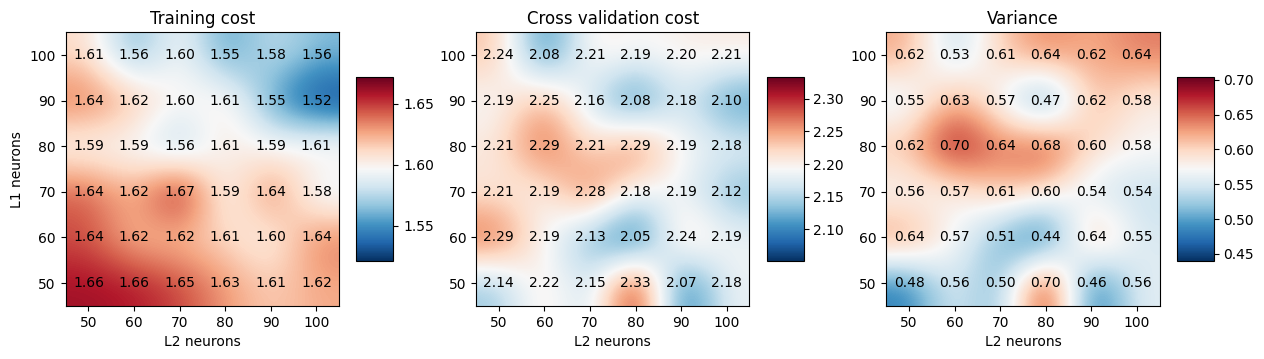

In [6]:
results_variance = results_vl - results_l

fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(15)
for ax, res, title in zip(axs, [results_l, results_vl, results_variance], ["Training cost", "Cross validation cost", "Variance"]):
    ax.set_xlabel("L2 neurons")
    ax.set_yticks(range(len(rng)), labels=rng)
    ax.set_xticks(range(len(rng)), labels=rng)
    imsh = ax.imshow(res, cmap="RdBu_r", interpolation='bicubic')
    ax.invert_yaxis()
    ax.set_title(title)
    fig.colorbar(imsh, shrink=0.5, aspect=5)
    for (j, i), label in np.ndenumerate(res):
        ax.text(i, j, f"{label:0.2f}", ha='center', va='center')
axs[0].set_ylabel("L1 neurons")
plt.show()


# Try different regularization values


In [7]:
results_by_lambda_l = []
results_by_lambda_vl = []
results_by_lambda_e = []
rng_lambdas = [0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
with tqdm(rng_lambdas) as pbar:
    for lambd in pbar:
        h, l, vl, e = try_setup(x=x, y=y, x_test=x_test, y_test=y_test, degrees=[1], regularize=None if lambd == 0 else lambd/10000, plot=False)
        results_by_lambda_l.append(l[0])
        results_by_lambda_vl.append(vl[0])
        results_by_lambda_e.append(e[0])


100%|██████████| 12/12 [00:45<00:00,  3.81s/it]


## Visualize results


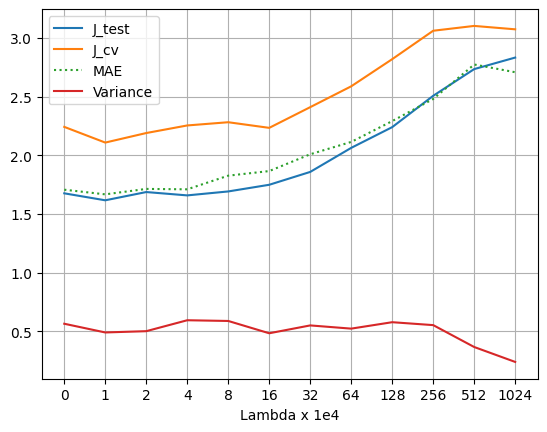

In [8]:
plt.plot(results_by_lambda_l, label="J_test")
plt.plot(results_by_lambda_vl, label="J_cv")
plt.plot(results_by_lambda_e, ":", label="MAE")
plt.plot(np.array(results_by_lambda_vl)-np.array(results_by_lambda_l), label="Variance")
plt.legend()
plt.grid()
plt.xticks(range(len(rng_lambdas)), labels=rng_lambdas)
plt.xlabel("Lambda x 1e4")
plt.show()
